In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#########################################
# STEP 1: Data Loading and Preprocessing
#########################################

# (This part supports all objectives by providing a clean dataset for analysis)
df = pd.read_csv('/Users/biplavbarua/Developer/Real_time_Air_Quality_Index_from_various_locations.csv')
print("Dataset preview:")
print(df.head())

# Convert date/time columns if they exist (supports Objective 4: Temporal Trends)
if 'last_update' in df.columns:
    df['last_update'] = pd.to_datetime(df['last_update'])
elif 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Handle missing values
print("\nMissing values summary:")
print(df.isnull().sum())
df = df.dropna()


Dataset preview:
  country           state           city  \
0   India  Andhra_Pradesh       Tirupati   
1   India  Andhra_Pradesh       Tirupati   
2   India  Andhra_Pradesh     Vijayawada   
3   India  Andhra_Pradesh     Vijayawada   
4   India  Andhra_Pradesh  Visakhapatnam   

                                  station          last_update   latitude  \
0         Vaikuntapuram, Tirupati - APPCB  12-04-2025 10:00:00  13.615387   
1         Vaikuntapuram, Tirupati - APPCB  12-04-2025 10:00:00  13.615387   
2   Rajiv Gandhi Park, Vijayawada - APPCB  12-04-2025 10:00:00  16.509717   
3   Rajiv Gandhi Park, Vijayawada - APPCB  12-04-2025 10:00:00  16.509717   
4  GVM Corporation, Visakhapatnam - APPCB  12-04-2025 10:00:00  17.720000   

   longitude pollutant_id  pollutant_min  pollutant_max  pollutant_avg  
0  79.409230          SO2            NaN            NaN            NaN  
1  79.409230        OZONE            NaN            NaN            NaN  
2  80.612222           CO           

In [2]:

#########################################
# STEP 2: Compute AQI if Missing
#########################################
# (This step is fundamental for the subsequent analyses)

# Define functions to compute AQI based on pollutant type using EPA breakpoints:
def compute_aqi_pm25(pm25):
    breakpoints = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500),
    ]
    aqi = None
    for bp in breakpoints:
        bp_low, bp_high, aqi_low, aqi_high = bp
        if bp_low <= pm25 <= bp_high:
            aqi = ((aqi_high - aqi_low) / (bp_high - bp_low)) * (pm25 - bp_low) + aqi_low
            break
    return int(aqi) if aqi is not None else -1

def compute_aqi_pm10(pm10):
    breakpoints = [
        (0, 54, 0, 50),
        (55, 154, 51, 100),
        (155, 254, 101, 150),
        (255, 354, 151, 200),
        (355, 424, 201, 300),
        (425, 504, 301, 400),
        (505, 604, 401, 500),
    ]
    aqi = None
    for bp in breakpoints:
        bp_low, bp_high, aqi_low, aqi_high = bp
        if bp_low <= pm10 <= bp_high:
            aqi = ((aqi_high - aqi_low) / (bp_high - bp_low)) * (pm10 - bp_low) + aqi_low
            break
    return int(aqi) if aqi is not None else -1

# Compute AQI based on pollutant_id and pollutant_avg (dataset-specific step)
def compute_aqi(row):
    pollutant = str(row['pollutant_id']).strip().upper()
    value = row['pollutant_avg']
    # Supports PM2.5 and PM10 computations
    if pollutant in ['PM2.5', 'PM2_5', 'PM25']:
        return compute_aqi_pm25(value)
    elif pollutant == 'PM10':
        return compute_aqi_pm10(value)
    else:
        return -1

df['AQI'] = df.apply(compute_aqi, axis=1)
print("Sample of computed AQI values:")
print(df[df['AQI'] != -1][['pollutant_id', 'pollutant_avg', 'AQI']].head())


Sample of computed AQI values:
   pollutant_id  pollutant_avg  AQI
4          PM10           85.0   65
13        PM2.5           60.0  153
17        PM2.5          163.0  213
20         PM10           96.0   71
25        PM2.5           46.0  126


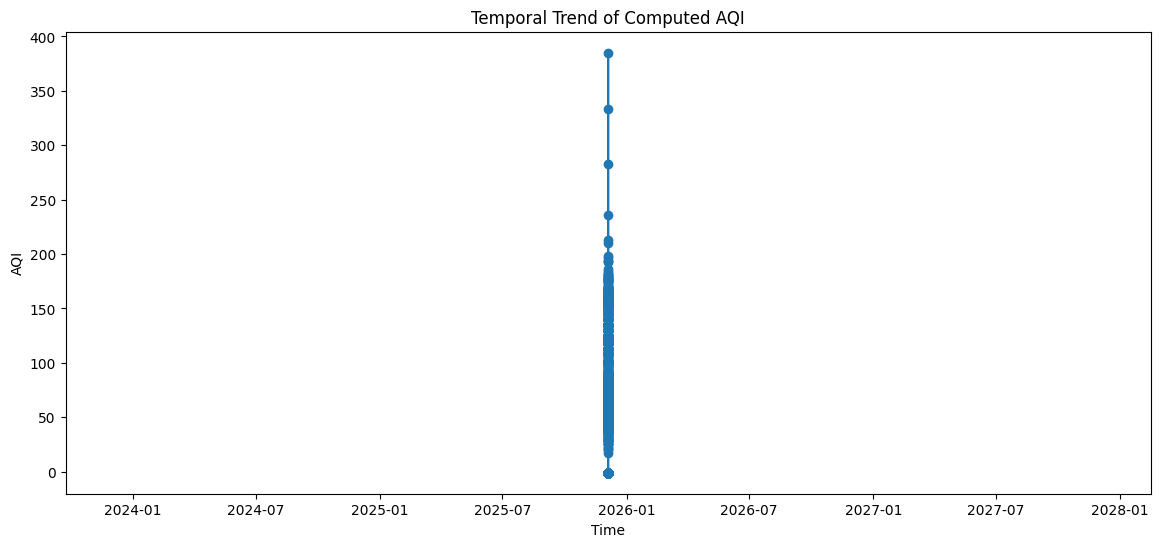

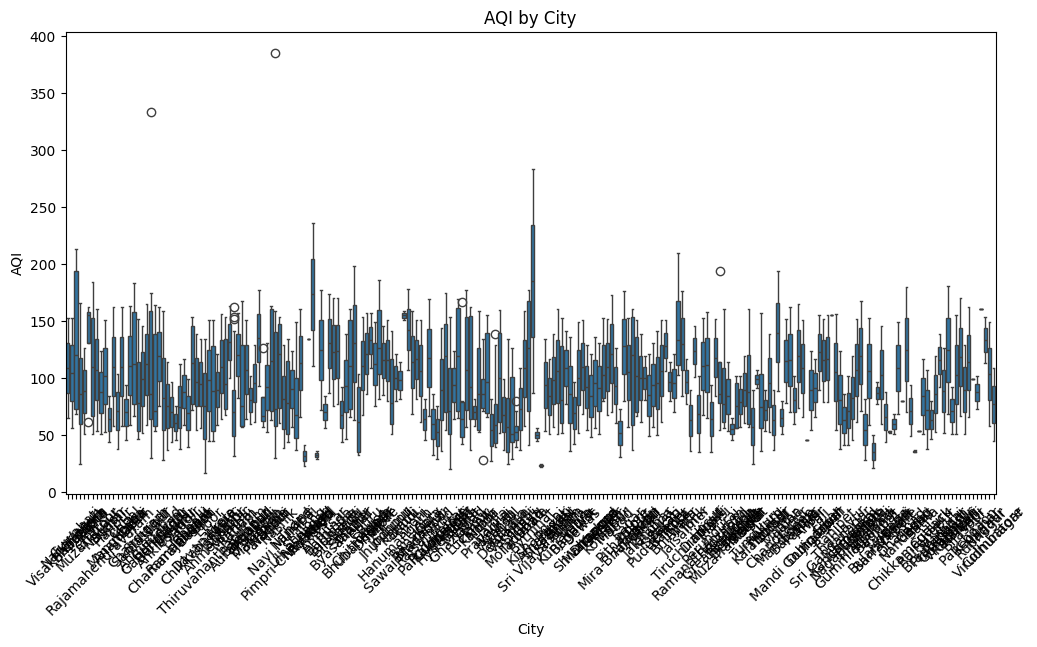

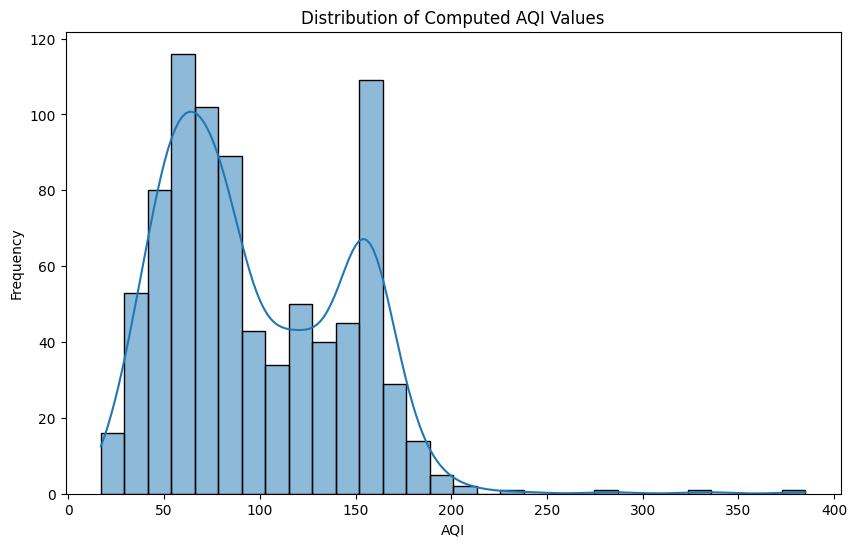

In [3]:

#########################################
# STEP 3: Exploratory Data Analysis (EDA)
#########################################

# Objective 4: Examine Temporal Trends in Air Quality and Public Health
if 'last_update' in df.columns:
    df_sorted = df.sort_values(by='last_update')
    plt.figure(figsize=(14, 6))
    plt.plot(df_sorted['last_update'], df_sorted['AQI'], marker='o', linestyle='-')
    plt.title('Temporal Trend of Computed AQI')
    plt.xlabel('Time')
    plt.ylabel('AQI')
    plt.show()

# Objective 3: Identify Regional Disparities in Health Outcomes Related to Air Quality
# Visualize AQI by city (or region); adjust 'city' to 'state' or 'country' if preferred.
if 'city' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[df['AQI'] != -1], x='city', y='AQI')
    plt.title('AQI by City')
    plt.xlabel('City')
    plt.ylabel('AQI')
    plt.xticks(rotation=45)
    plt.show()

# Distribution of AQI values
plt.figure(figsize=(10, 6))
sns.histplot(df[df['AQI'] != -1]['AQI'], bins=30, kde=True)
plt.title('Distribution of Computed AQI Values')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()


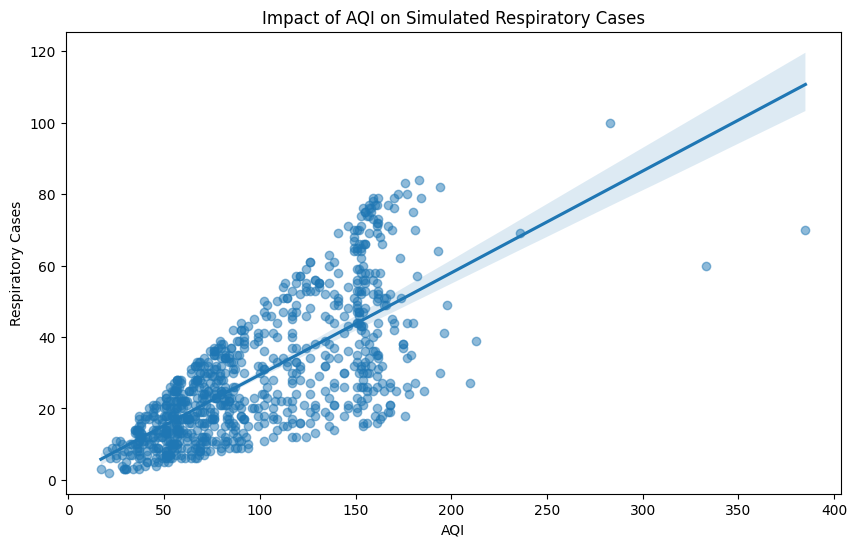

Correlation between AQI and respiratory cases: 0.72


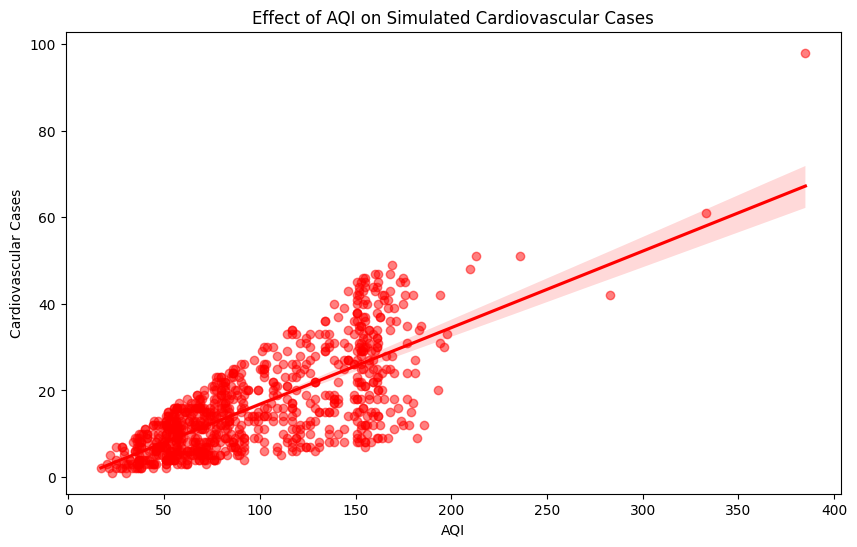

Correlation between AQI and cardiovascular cases: 0.73


In [4]:

#########################################
# STEP 4: Simulate Health Outcomes
#########################################
# Objective 1: Assess the Impact of Air Quality on Respiratory Diseases  
# Objective 2: Evaluate the Effect of Air Pollution on Cardiovascular Health
np.random.seed(42)  # For reproducibility
df['respiratory_cases'] = (df['AQI'] * np.random.uniform(0.1, 0.5, len(df))).astype(int)
df['cardiovascular_cases'] = (df['AQI'] * np.random.uniform(0.05, 0.3, len(df))).astype(int)

# Plot for Respiratory Cases vs. AQI
plt.figure(figsize=(10, 6))
sns.regplot(x='AQI', y='respiratory_cases', data=df[df['AQI'] != -1], scatter_kws={'alpha':0.5})
plt.title('Impact of AQI on Simulated Respiratory Cases')
plt.xlabel('AQI')
plt.ylabel('Respiratory Cases')
plt.show()
corr_resp = df.loc[df['AQI'] != -1, 'AQI'].corr(df.loc[df['AQI'] != -1, 'respiratory_cases'])
print(f"Correlation between AQI and respiratory cases: {corr_resp:.2f}")

# Plot for Cardiovascular Cases vs. AQI
plt.figure(figsize=(10, 6))
sns.regplot(x='AQI', y='cardiovascular_cases', data=df[df['AQI'] != -1], scatter_kws={'alpha':0.5}, color='red')
plt.title('Effect of AQI on Simulated Cardiovascular Cases')
plt.xlabel('AQI')
plt.ylabel('Cardiovascular Cases')
plt.show()
corr_card = df.loc[df['AQI'] != -1, 'AQI'].corr(df.loc[df['AQI'] != -1, 'cardiovascular_cases'])
print(f"Correlation between AQI and cardiovascular cases: {corr_card:.2f}")



Predictive Model Evaluation:
Mean Squared Error: 164.38
R-squared: 0.54


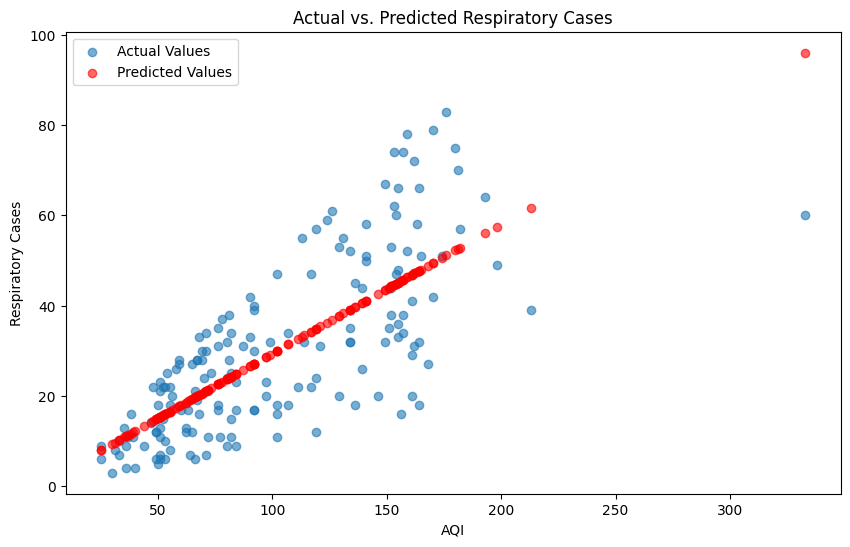

In [5]:

#########################################
# STEP 5: Predictive Modeling
#########################################
# Objective 5: Develop Predictive Models for Health Outcomes Based on Air Quality Forecasts
# Using linear regression to predict respiratory_cases from AQI
df_valid = df[df['AQI'] != -1]
X = df_valid[['AQI']]
y = df_valid['respiratory_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nPredictive Model Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, alpha=0.6, label='Actual Values')
plt.scatter(X_test, y_pred, alpha=0.6, label='Predicted Values', color='red')
plt.xlabel("AQI")
plt.ylabel("Respiratory Cases")
plt.title("Actual vs. Predicted Respiratory Cases")
plt.legend()
plt.show()


Area Type Value Counts:
area_type
Urban    2565
Rural     323
Name: count, dtype: int64


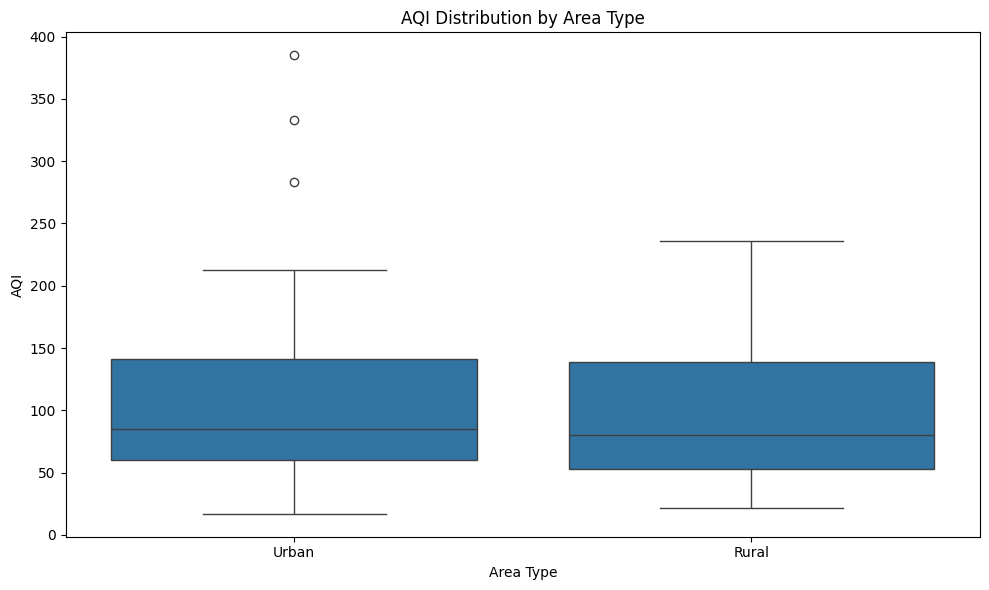

Mean Health Outcomes by Area Type:
  area_type  respiratory_cases  cardiovascular_cases
0     Rural          27.419355             15.473118
1     Urban          28.956640             16.508130


/var/folders/bw/5tc2sfgd3_dg6w_6rv0h5zq80000gn/T/ipykernel_36859/2173346578.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_health, x='area_type', y='cardiovascular_cases', palette='Reds', ax=axes[1])


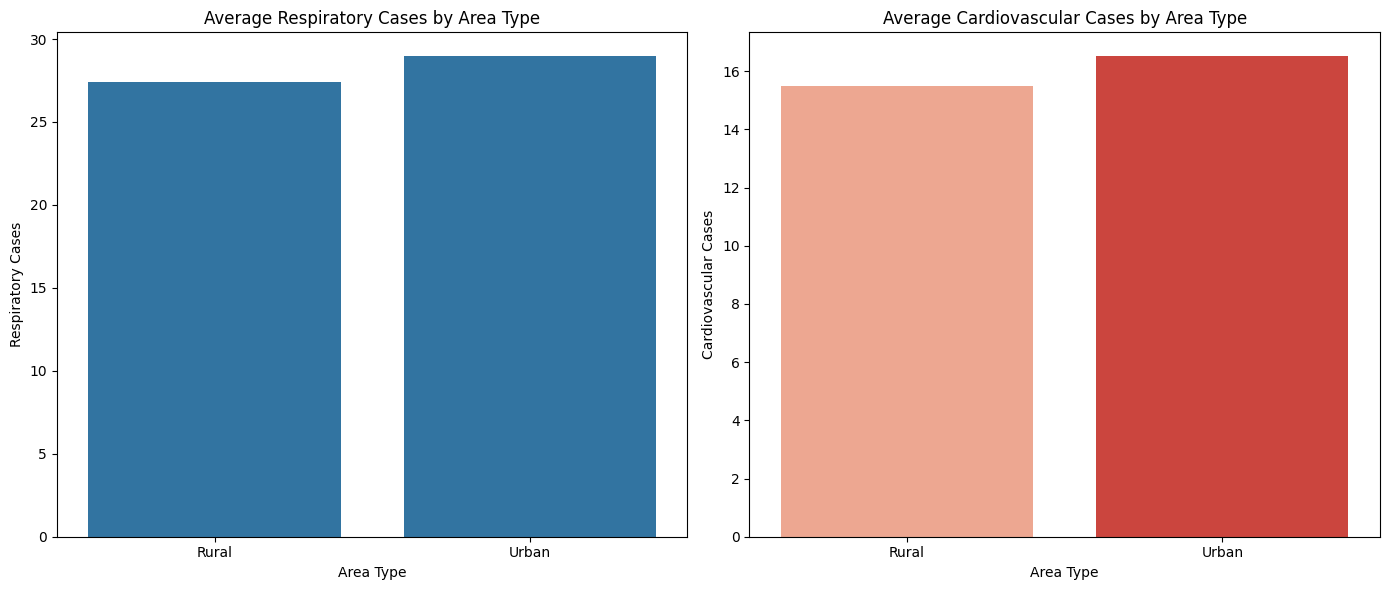

In [6]:

#########################################
# STEP 6: Evaluate Urbanization/Industrialization Effects
#########################################
# Objective 6: Evaluate the Effect of Urbanization and Industrialization on Public Health in Relation to Air Quality
# Derive urban vs. rural classification automatically from the dataset.
if 'city' not in df.columns:
    raise ValueError("No 'city' column available to derive urbanization information.")

# Determine which cities are "urban" by using the frequency of occurrence in the dataset.
city_counts = df['city'].value_counts()
threshold = city_counts.median()  # Cities appearing more than the median are considered urban
urban_cities = city_counts[city_counts >= threshold].index.tolist()

# Create the area_type column based on the derived urban cities from the dataset.
df['area_type'] = df['city'].apply(lambda x: 'Urban' if x in urban_cities else 'Rural')
print("Area Type Value Counts:")
print(df['area_type'].value_counts())

# Visualize AQI distribution by derived area_type (Objective 3 & 6)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['AQI'] != -1], x='area_type', y='AQI')
plt.title('AQI Distribution by Area Type')
plt.xlabel('Area Type')
plt.ylabel('AQI')
plt.tight_layout()
plt.show()

# Aggregate simulated health outcomes by area_type
agg_health = df[df['AQI'] != -1].groupby('area_type')[['respiratory_cases', 'cardiovascular_cases']].mean().reset_index()
print("Mean Health Outcomes by Area Type:")
print(agg_health)

# Create subplots to visualize health outcomes for Urban vs. Rural
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.barplot(data=agg_health, x='area_type', y='respiratory_cases', ax=axes[0])
axes[0].set_title('Average Respiratory Cases by Area Type')
axes[0].set_xlabel('Area Type')
axes[0].set_ylabel('Respiratory Cases')
sns.barplot(data=agg_health, x='area_type', y='cardiovascular_cases', palette='Reds', ax=axes[1])
axes[1].set_title('Average Cardiovascular Cases by Area Type')
axes[1].set_xlabel('Area Type')
axes[1].set_ylabel('Cardiovascular Cases')
plt.tight_layout()
plt.show()
